In [1]:
import pandas as pd

In [15]:
df = pd.read_csv("E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/04_normalization_model_input/normalized_model_input.csv")

In [7]:
df.head(3)

,Date,stock_id,Open,High,Low,Close,Volume,MA7,MA21,EMA20,...,BB_upper,BB_middle,BB_lower,CCI_14,CMF_20,Stoch_K,Stoch_D,Momentum_10,Daily_Return,Log_Return
0,2021-12-14,ANANDRATHI,287.24,294.42,270.75,279.37,27861900.0,274.57858,284.5581,283.8015,...,257.13663,283.8015,310.46637,-4213.020993,-0.169092,80.29088,84.21576,-5.51,0.002398,0.002395
1,2021-12-15,ANANDRATHI,280.06,286.67,276.71,280.04,2675624.0,274.57858,284.5581,283.8015,...,257.13663,283.8015,310.46637,-4213.020993,-0.169092,80.29088,84.21576,-5.51,0.002398,0.002395
2,2021-12-16,ANANDRATHI,280.54,284.61,271.01,273.31,1329736.0,274.57858,284.5581,283.8015,...,257.13663,283.8015,310.46637,-4213.020993,-0.169092,80.29088,84.21576,-5.51,-0.024032,-0.024326


In [18]:
# Example: summarize each stock’s normalized indicators
cluster_features = (
    df
    .groupby('stock_id')
    .agg({
        'Close': ['mean', 'std', 'skew'],
        'Volume': ['mean', 'std'],
        'RSI_14': 'mean',
        'MACD': 'mean',
        'EMA20': 'mean',
        'BB_upper': 'mean',
        'BB_lower': 'mean',
        'Stoch_K': 'mean'
    })
)

# Flatten multi-index columns
cluster_features.columns = ['_'.join(col) for col in cluster_features.columns]
cluster_features.reset_index(inplace=True)


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = cluster_features.drop(['stock_id'], axis=1)
best_score = -1
best_k = None

for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k={k} → Silhouette Score = {score:.3f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best cluster count = {best_k}")

k=2 → Silhouette Score = 0.777
k=3 → Silhouette Score = 0.689
k=4 → Silhouette Score = 0.687
k=5 → Silhouette Score = 0.610
k=6 → Silhouette Score = 0.593
k=7 → Silhouette Score = 0.551
k=8 → Silhouette Score = 0.486
k=9 → Silhouette Score = 0.479
Best cluster count = 2


In [20]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(X)

In [24]:
cluster_features.head(2)

,stock_id,Close_mean,Close_std,Close_skew,Volume_mean,Volume_std,RSI_14_mean,MACD_mean,EMA20_mean,BB_upper_mean,BB_lower_mean,Stoch_K_mean,cluster
0,ANANDRATHI,1171.873834,821.832909,0.306982,2.315982e+05,9.868963e+05,58.697560,19.559556,1145.217214,1059.640785,1230.211083,56.962060,1
1,AXISBANK,855.369206,236.601928,-0.196035,1.316032e+07,1.101492e+07,52.230762,1.667351,852.784179,802.883356,902.509444,54.267986,0


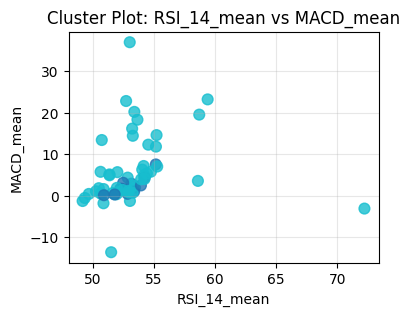

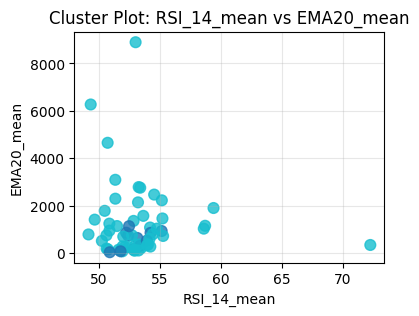

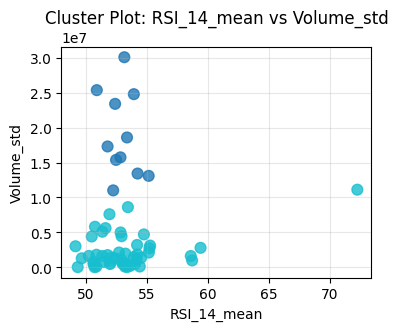

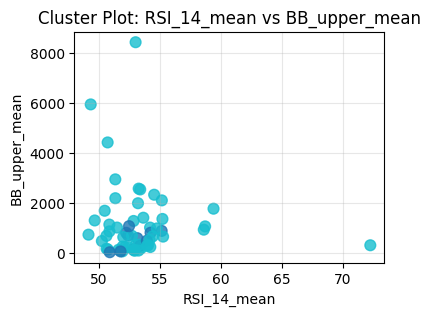

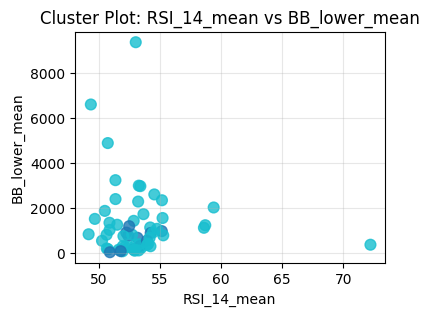

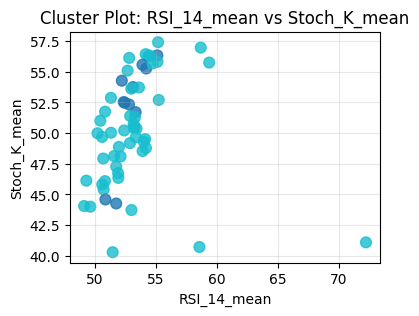

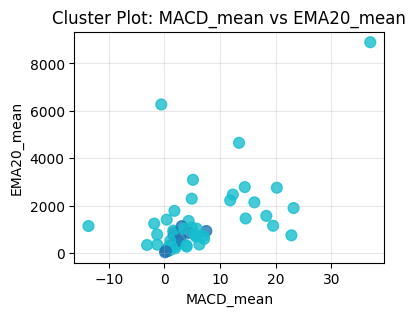

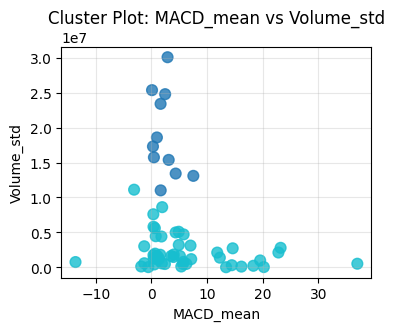

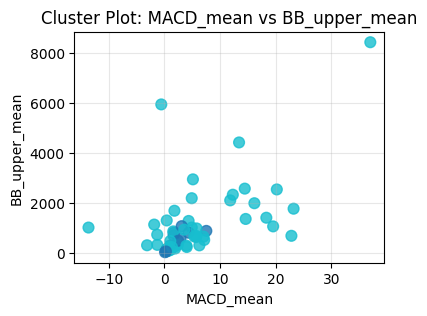

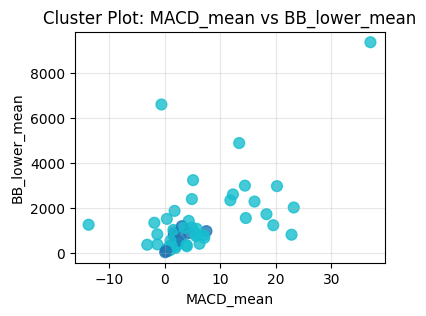

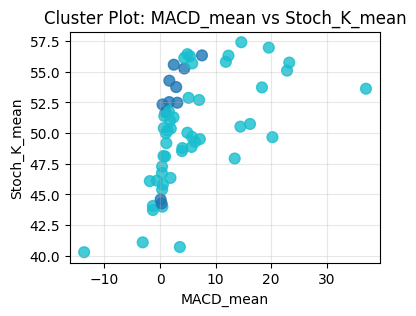

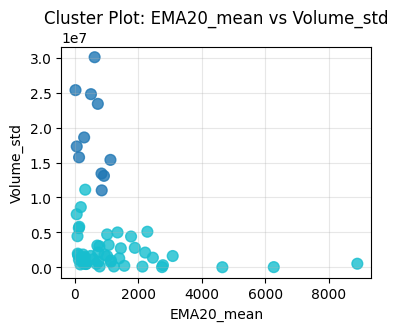

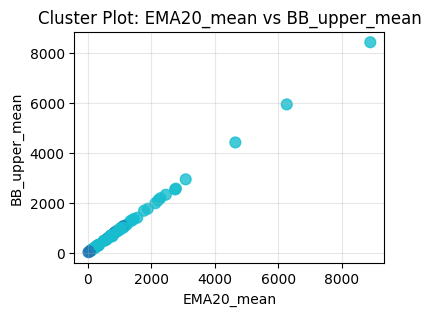

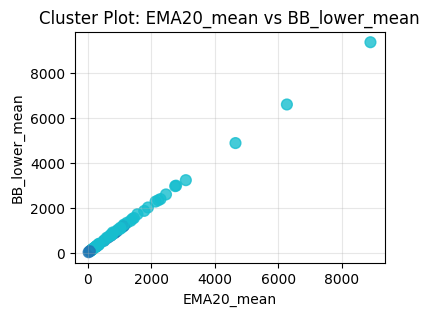

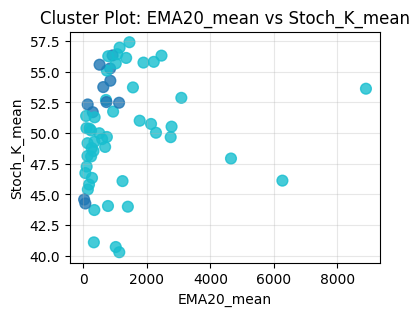

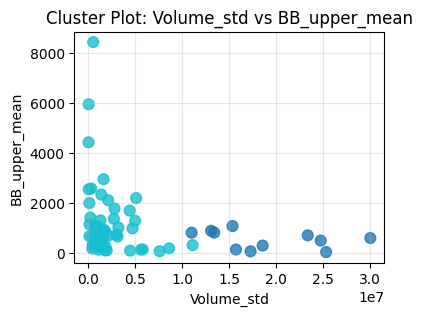

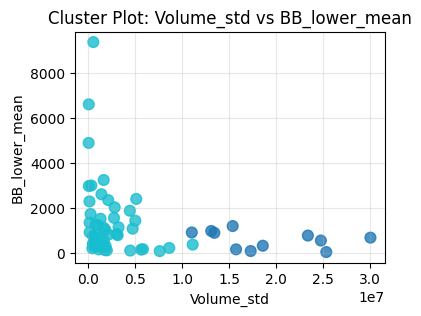

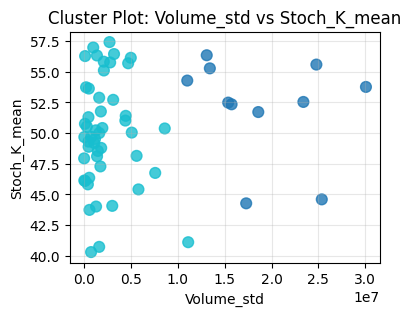

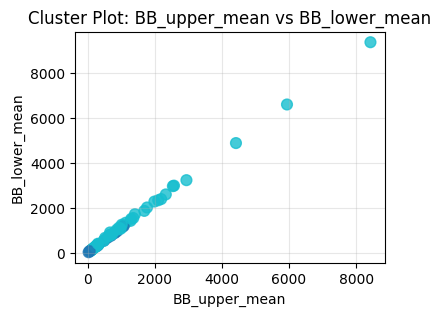

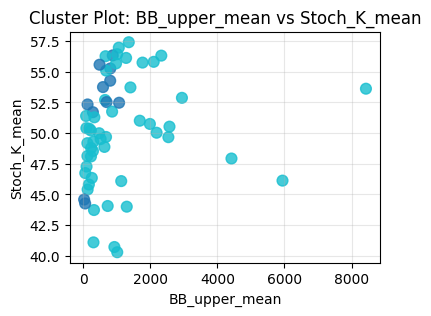

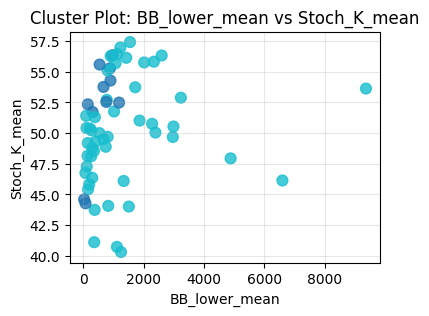

In [31]:
import matplotlib.pyplot as plt
features_to_plot = ['RSI_14_mean', 'MACD_mean', 'EMA20_mean', 'Volume_std','BB_upper_mean','BB_lower_mean','Stoch_K_mean']

import itertools
for x_feature, y_feature in itertools.combinations(features_to_plot, 2):
    plt.figure(figsize=(4,3))
    plt.scatter(cluster_features[x_feature], cluster_features[y_feature],
                c=cluster_features['cluster'], cmap='tab10', s=60, alpha=0.8)
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f'Cluster Plot: {x_feature} vs {y_feature}')
    plt.grid(alpha=0.3)
    plt.show()


In [13]:
cluster_summary = df.merge(cluster_features[['stock_id', 'cluster']], on='stock_id')
cluster_summary.groupby('cluster')['stock_id'].unique()

cluster
0    [AXISBANK, BAJFINANCE, BHARTIARTL, HDFCBANK, I...
1    [ANANDRATHI, CAMS, CASTROLIND, CDSL, CRIZAC, E...
Name: stock_id, dtype: object